## Analysis

You will need to install both `networkx` (using `pip`) and `matplotlib` (see <http://matplotlib.org/users/installing.html> for installation instructions)

In [1]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import matplotlib.pyplot as plt
from rdflib import ConjunctiveGraph
from timeit import default_timer as timer
%matplotlib inline  

In [2]:
prefix = "PREFIX : <http://data.krw.d2s.labs.vu.nl/group12/vocab/>"
TUTORIAL_REPOSITORY = "http://stardog.krw.d2s.labs.vu.nl/group12"
endpoint = TUTORIAL_REPOSITORY + "/query"

In [3]:
def clearStardog():
    """Careful! This one clears the entire stardog repository specified in TUTORIAL_REPOSITORY"""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/clear"
    response = requests.post(post_url, headers={'Accept': 'text/plain'})
    
    print "Sent clear request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def upload_file_to_stardog(filename, mimetype='application/trig'):
    """Well, obvious what this does... you can set the 'mimetype' to e.g. text/turtle if you want to upload a turtle file"""
    with open(filename,'r') as f:
        data = f.read()
        
    upload_to_stardog(data, mimetype=mimetype)
    
    return
    

def upload_to_stardog(data, mimetype='application/trig'):
    """Upload data to Stardog, you know this one from the previous assignments..."""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/add"
    response = requests.post(post_url, data=data, headers={'Accept': 'text/plain', 'Content-type': mimetype}, stream=True)

    print "Sent add request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def getJunctionMatches(reasoning='false', max=None):
    '''Get all TrafficLightJunctions that are spatially equal or close to a Junction'''
    query = '''
PREFIX krv: <http://data.krw.d2s.labs.vu.nl/group12/vocab/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX unit: <http://qudt.org/vocab/unit#>

SELECT ?junc ?tljunc WHERE {
  ?junc     a                   krv:Junction ;
            geo:hasGeometry     ?geo1 .
  ?tljunc   a                   krv:TrafficlightJunction ;
            geo:hasGeometry     ?geo2 .
  FILTER(geof:distance(?geo1, ?geo2, unit:Meter) < 20)
}'''
    if max != None:
        query = query + ' LIMIT ' + str(max)
    
    return [(r['junc']['value'], r['tljunc']['value']) for r in runQuery(query, reasoning)]
    
def getClasses(reasoning='true', max=None):
    """Get all classes from the repo, optionally with a limit of `max`"""
    if max is None :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class }"""
    else :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class } LIMIT """ + str(max)
    
    return [r['c']['value'] for r in runQuery(query, reasoning)]
    

def getInstances(className, reasoning='true', max=None, graph=None):
    """Get the instances for a class.. be sure to include < and > around its URI"""
    query = prefix + """
    SELECT ?i WHERE {{?i a {} . }}
    """.format(className)
    if max != None:
        query = query + ' LIMIT ' + str(max)
    if graph:
        return [r[0] for r in graph.query(query)]
    else:
        return [r['i']['value'] for r in runQuery(query, reasoning)]

def countUsage(reasoning='true', max=None):
    """Count the number of occurrences of a resource. Will differ significantly if reasoning is 'false'"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'resource' in r:
            index[unicode(r['resource']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index


def countClassUsage(reasoning='true', max=None):
    """Count how many (inferred) instances a class has"""
    query = """
        SELECT ?class (COUNT(?resource) as ?count) WHERE {
            ?resource a ?class . 
        } GROUP BY ?class ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'class' in r:
            index[unicode(r['class']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index

def countUsageLocal(rdfgraph, max=None):
    """Count usage of a resource on a local RDFLib graph"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY ?resource
    """
    
    results = g.query(query)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
            
        index[unicode(r['resource'])] = int(r['count'])
        
        count += 1
    
    return index
    

def runQuery(query, reasoning='true'):
    """Run a SPARQL query against the endpoint"""
    sparql = SPARQLWrapper(endpoint)

    sparql.setQuery(query)

    sparql.setReturnFormat(JSON)
    sparql.addParameter('Accept','application/sparql-results+json')

    sparql.addParameter('reasoning',reasoning)

    response = sparql.query().convert()

    return response['results']['bindings']

def avg(myList, toString=False):
    temp = sum(myList) / float(len(myList))
    return str(temp) if toString else temp

def runQueryTests(classes, numruns=10, graph=None):
    myResults = {}
    for myClass in classes:
        # initialize dicts
        myResults[myClass] = {}
        myResults[myClass]['false'] = {}
        myResults[myClass]['false']['time'] = []
        myResults[myClass]['true'] = {}
        myResults[myClass]['true']['time'] = []
        # run the query with and without reasoning
        for reasoning in ['false','true']:
            # do multiple runs to calculate average runtime
            for run in range(numruns):
                start = timer()
                temp = getInstances('<http://data.krw.d2s.labs.vu.nl/group12/vocab/{}>'.format(myClass), reasoning=reasoning, graph=graph)
                end = float(timer() - start)
                myResults[myClass][reasoning]['time'].append(end)
            myResults[myClass][reasoning]['data'] = temp
    return myResults

def printQueryTestResults(data, maxResults=10):
    for classKey, classValue in data.iteritems():
        print 'Class: ' + classKey
        for reasonKey, reasonValue in classValue.iteritems():
            print '...' + ('reasoning' if reasonKey == 'true' else 'no reasoning')
            print '......average runtime: ' + avg(reasonValue['time'], toString=True) + ' seconds'
            if not reasonValue['data']: # is empty?
                print '......(no results)'
            for i, myResult in enumerate(reasonValue['data']):
                if i > maxResults:
                    print '......(more results omitted)'
                    break
                print '......' + str(i) + ': ' + str(myResult)

### Example analysis

Upload the example files to Stardog

In [12]:
# upload_file_to_stardog('o1.trig')
# upload_file_to_stardog('o2.trig')
# upload_file_to_stardog('d1.trig')
# upload_file_to_stardog('d2.trig')

In [13]:
start = timer()
result0 = getClasses(max=1000, reasoning='false')
end = timer()
print str(end - start) + ' seconds'

0.0369027479408 seconds


In [14]:
result0

[u'http://data.krw.d2s.labs.vu.nl/group12/vocab/RoadSection',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Town',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Junction',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/TrafficAccident',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Street',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Trafficlight',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Accident',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/TrafficlightJunction',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Event',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Location',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/DangerousJunction',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/DangerousRoadSection',
 u'bnode_6d8298e3_266c_474a_8342_9a4e9db3d9d5_1925',
 u'bnode_6d8298e3_266c_474a_8342_9a4e9db3d9d5_1930',
 u'bnode_6d8298e3_266c_474a_8342_9a4e9db3d9d5_1935',
 u'bnode_6d8298e3_266c_474a_8342_9a4e9db3d9d5_1940',
 u'bnode_6d8298e3_266c_474a_8342_9a4e9db3d

In [15]:
start = timer()
result0 = getClasses(max=1000, reasoning='true')
end = timer()
print str(end - start) + ' seconds'

0.039065943326 seconds


In [16]:
result0

[u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Location',
 u'http://www.opengis.net/ont/sf#Point',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Town',
 u'http://rdfs.org/ns/void#Dataset',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Event',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Trafficlight',
 u'http://www.w3.org/2002/07/owl#Nothing',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/DangerousRoadSection',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/TrafficlightJunction',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/RoadSection',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/DangerousJunction',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Junction',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Accident',
 u'http://www.w3.org/2002/07/owl#Thing',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Street',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/TrafficAccident',
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Address']

Now get all classes from the repository. Select one, and use its URI to retrieve instances.

(Play around with reasoning 'false' and 'true')

In [17]:
start = timer()
result1 = getJunctionMatches(reasoning='false', max=10)
end = timer()
print str(end - start) + ' seconds'

20.2107336304 seconds


In [18]:
result1

[(u'http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/242368116',
  u'http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/688'),
 (u'http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/246372204',
  u'http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/87'),
 (u'http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/246372204',
  u'http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/87'),
 (u'http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/246372205',
  u'http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/87'),
 (u'http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/246372205',
  u'http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/87'),
 (u'http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/239374030',
  u'http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/69'),
 (u'http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/239374030',
  u'http://dat

In [19]:
# trafficlightjunction subclassof junction
# trafficaccident has from and to properties which is equivalent to an event
# junction, roadsections, etc. are subclassesof location
# junction or roadsection with at least 1 trafficaccident is dangerous (doesn't work in stardog)
myInferredClasses = ['Junction','Event','Location','DangerousJunction','DangerousRoadSection']

Try several queries with and without reasoning.

In [20]:
testResults = runQueryTests(myInferredClasses)

In [21]:
printQueryTestResults(testResults)

Class: DangerousJunction
...reasoning
......average runtime: 0.0313237945092 seconds
......(no results)
...no reasoning
......average runtime: 0.035095135797 seconds
......(no results)
Class: Junction
...reasoning
......average runtime: 2.33950775572 seconds
......0: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/688
......1: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/87
......2: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/69
......3: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/100
......4: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/104
......5: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/52
......6: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/63
......7: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/308
......8: http://data.krw.d2s.labs.vu.nl/group12/resource/TrafficlightJunction/345
......9

### Locally

Load the example files in an RDFLib graph (locally). Note that a large graph may become problematic (given memory limitations).

A `ConjunctiveGraph` object allows for loading named graphs, but hides them (i.e. you don't need to think about the graphs when querying the data).

In [22]:
g = ConjunctiveGraph()

g += g.parse('trafficlights-rdf.trig', format='trig')
g += g.parse('trafficaccidents-rdf.trig', format='trig')
g += g.parse('roadsections-rdf.trig', format='trig')


Try running the query tests on the local data.

In [23]:
localTestResults = runQueryTests(myInferredClasses, graph=g)

In [24]:
printQueryTestResults(localTestResults)

Class: DangerousJunction
...reasoning
......average runtime: 0.00435753737062 seconds
......(no results)
...no reasoning
......average runtime: 0.00430821480912 seconds
......(no results)
Class: Junction
...reasoning
......average runtime: 0.391283559928 seconds
......0: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/243385048
......1: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/247373089
......2: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/250378124
......3: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/235376013
......4: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/240380013
......5: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/238370003
......6: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/248374068
......7: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/241378017
......8: http://data.krw.d2s.labs.vu.nl/group12/resource/Junction/245372136
......9: http://data.krw.d2s.labs.vu.nl/group12/resou

Several simple statistics. The following code uses the `index` variable. Adjust where needed (e.g. replace `index` with `index_remote`)

In [25]:
index = countUsageLocal(g)

In [26]:
# index

In [27]:
index_remote = countUsage(reasoning='false')

In [28]:
# index_remote

In [29]:
index_classes = countClassUsage(reasoning='true')

In [46]:
index_classes

{u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Accident': 19041,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Event': 19041,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Junction': 17117,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Location': 46978,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/RoadSection': 23956,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Street': 5348,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Town': 1,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/TrafficAccident': 19041,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/Trafficlight': 556,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab/TrafficlightJunction': 556,
 u'http://rdfs.org/ns/void#Dataset': 3,
 u'http://www.opengis.net/ont/sf#Point': 41104,
 u'http://www.w3.org/2002/07/owl#Thing': 107161}

Get the frequencies for each resource, and sort by frequency value.

Plot them at loglog scale

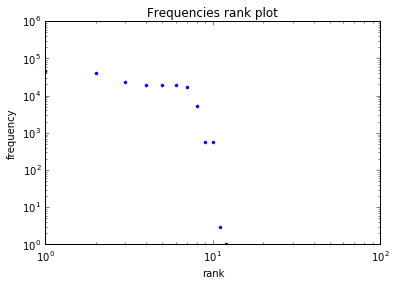

In [44]:
frequencies_by_value = sorted(index_classes.values(), reverse=True)

plt.loglog(frequencies_by_value,'b-',linestyle='None', marker='.')
plt.title("Frequencies rank plot")
plt.ylabel("frequency")
plt.xlabel("rank")

Get the frequencies for each resource, and sort by URI name (i.e. alphabetically)

Plot them at loglog scale

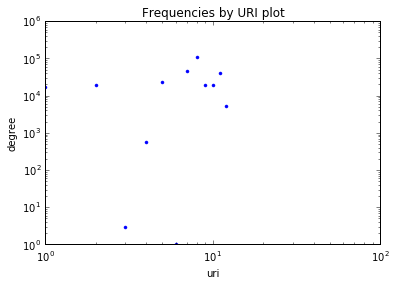

In [45]:
frequencies_by_URI = index_classes.values()

plt.loglog(frequencies_by_URI,'b-',linestyle='None', marker='.')
plt.title("Frequencies by URI plot")
plt.ylabel("degree")
plt.xlabel("uri")

### Network Analysis

Build a directed `networkx` graph from the RDF graph

In [35]:
def buildNetwork(rdfgraph, query = """SELECT * WHERE {?source ?edge ?target.}""", max=None):
    ## Query is assumed to have a source, target and edge
    
    results = g.query(query)
    
    G = nx.DiGraph()
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        G.add_edge(r['source'], r['target'], {'type': r['edge']})
        
        count += 1
        
    return G


In [36]:
G = buildNetwork(g, max=1000)

Get the degrees for each node in the graph, and sort them from large to small

In [37]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence

# And see what it looks like...
if len(degree_sequence) > 100:
    print len(degree_sequence), degree_sequence[:100]

1368 [158, 48, 40, 34, 32, 29, 20, 20, 20, 16, 16, 16, 15, 13, 12, 11, 10, 9, 9, 8, 7, 7, 6, 5, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Plot the graph using a spring layout (warning, may be very slow for large graphs)

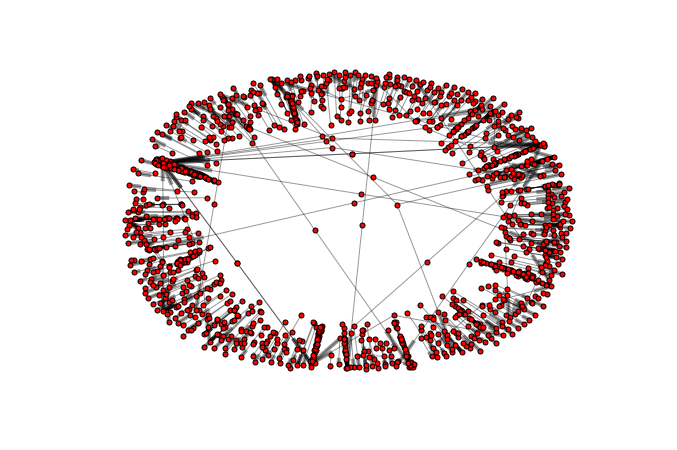

In [38]:
# draw graph in inset
plt.axes([1.45,1.45,1.45,1.45])
#Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G,pos,node_size=25)
nx.draw_networkx_edges(G,pos,alpha=0.4)

# plt.savefig("graph.png")
plt.show()

Plot the degrees at loglog scale

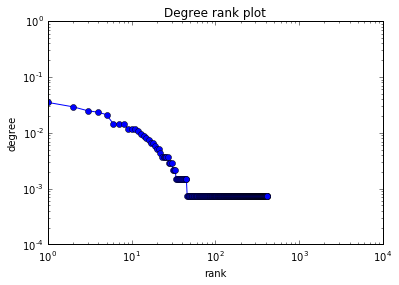

In [39]:
indegree_sequence=sorted(nx.in_degree_centrality(G).values(),reverse=True) # degree sequence
dmax=max(indegree_sequence)

plt.loglog(indegree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

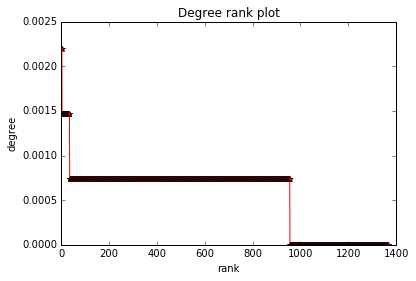

In [40]:
outdegree_sequence=sorted(nx.out_degree_centrality(G).values(),reverse=True) # degree sequence
dmax=max(outdegree_sequence)

plt.plot(outdegree_sequence,'r-',marker='*')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

You can also do Pagerank on the graph (have a look at the `networkx` documentation)

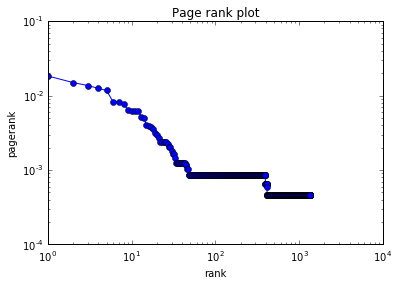

In [41]:
pagerank_sequence=sorted(nx.pagerank(G).values(),reverse=True) # degree sequence
dmax=max(pagerank_sequence)

plt.loglog(pagerank_sequence,'b-',marker='o')
plt.title("Page rank plot")
plt.ylabel("pagerank")
plt.xlabel("rank")